In [174]:
import pandas as pd
# Remove the limit on the number of columns displayed
pd.set_option('display.max_columns', None)

#### Load the modelling dataset

In [121]:
# Load your dataset for training
file_path = "modelling_table.csv"
data = pd.read_csv(file_path)

# Drop unnecessary columns
drop_columns = [
    'Team 1',
    'Team 2',
    'Unnamed: 0',
    'H2H_Home_Total_Wins_Last_4',
    'H2H_Away_Total_Wins_Last_4',
    'H2H_Draws_Last_4',
    'B365H',
    'B365D',
    'B365A'
]
data.drop(columns=drop_columns, inplace=True)

#### Load the prediction dataset

In [124]:
# Load your predictions file for new fixtures
predictions_file_path = r"prediction_data.csv"
new_fixtures = pd.read_csv(predictions_file_path)

# Make a copy of new_fixtures before dropping team columns
nf_copy = new_fixtures.copy()

# Drop unnecessary columns from new_fixtures
new_fixtures.drop(columns=drop_columns, inplace=True)

# Drop target columns after making a copy
new_fixtures.drop(columns=["Team 1 Score", "Team 2 Score"], inplace=True)

#### Win Loss Training using stacking classifier

In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.impute import SimpleImputer

data1 = data.copy()
# Define features and target for Win/Draw/Loss
X = data1.drop(columns=["Team 1 Score", "Team 2 Score"])
y = np.where(data1["Team 1 Score"] > data["Team 2 Score"], 0,   # Team 1 Win
             np.where(data["Team 1 Score"] == data["Team 2 Score"], 1,  # Draw
                      2))  # Team 2 Win

# Handle missing values using SimpleImputer on features only
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Base models
base_models = [
    ('win_model', LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42)),
    ('draw_model', LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42)),
    ('loss_model', LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42))
]

# Stacking Classifier
meta_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42)
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Store results
accuracy_list = []
classification_reports = []

for train_index, test_index in kf.split(X_imputed):
    X_train, X_test = X_imputed.iloc[train_index], X_imputed.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]  # Using y for predictions

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the stacking model
    stacked_model.fit(X_train_scaled, y_train)  # Ensure y_train is 1D

    # Make predictions
    y_pred = stacked_model.predict(X_test_scaled)

    # Calculate accuracy and store results
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    classification_reports.append(classification_report(y_test, y_pred, output_dict=True))

# Output average accuracy and classification report
average_accuracy = np.mean(accuracy_list)
print("Average Accuracy:", average_accuracy)

# Print detailed classification reports for each fold
for i, report in enumerate(classification_reports):
    print(f"\nClassification Report for Fold {i + 1}:\n", report)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Average Accuracy: 0.4237553342816501

Classification Report for Fold 1:
 {'0': {'precision': 0.5, 'recall': 0.7647058823529411, 'f1-score': 0.6046511627906976, 'support': 17.0}, '1': {'precision': 0.25, 'recall': 0.125, 'f1-score': 0.16666666666666666, 'support': 8.0}, '2': {'precision': 0.375, 'recall': 0.23076923076923078, 'f1-score': 0.2857142857142857, 'support': 13.0}, 'accuracy': 0.4473684210526316, 'macro avg': {'precision': 0.375, 'recall': 0.3734917043740573, 'f1-score': 0.35234403839055, 'support': 38.0}, 'weighted avg': {'precision': 0.40460526315789475, 'recall': 0.4473684210526316, 'f1-score': 0.4033339161858133, 'support': 38.0}}

Classification Report for Fold 2:
 {'0': {'precision': 0.4074074074074074, 'recall': 0.7857142857142857, 'f1-score': 0.5365853658536586, 'support': 14.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11.0}, '2': {'precision': 0.45454545454545453, 'recall': 0.38461538461538464, 'f1-score': 0.4166666666666667, 'support': 13.0

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Win Loss Prediction of stacking classifier

In [133]:

# Standardize features for new fixtures
new_fixtures_scaled = scaler.transform(new_fixtures)

# Make predictions for new fixtures
predictions = stacked_model.predict(new_fixtures_scaled)

# Get probabilities for each outcome
probabilities = stacked_model.predict_proba(new_fixtures_scaled)

# Map predictions to results
prediction_labels = {0: 'Team 1 Wins', 1: 'Draw', 2: 'Team 2 Wins'}
predictions_results = [prediction_labels[pred] for pred in predictions]

# Add predictions and probabilities to the DataFrame
new_fixtures['Predictions'] = predictions_results
new_fixtures['Team 1 Win Probability'] = probabilities[:, 0]
new_fixtures['Draw Probability'] = probabilities[:, 1]
new_fixtures['Team 2 Win Probability'] = probabilities[:, 2]

# Combine the team names from nf_copy with the predictions and probabilities
final_output = nf_copy.copy()
final_output['Predictions'] = predictions_results
final_output['Team 1 Win Probability'] = probabilities[:, 0]
final_output['Draw Probability'] = probabilities[:, 1]
final_output['Team 2 Win Probability'] = probabilities[:, 2]

# Display team names and predictions with probabilities
final_output[['Team 1', 'Team 2', 'Predictions', 'Team 1 Win Probability', 'Draw Probability', 'Team 2 Win Probability']].head()


,Team 1,Team 2,Predictions,Team 1 Win Probability,Draw Probability,Team 2 Win Probability
0,West Ham,Fulham,Draw,0.285176,0.378181,0.336644
1,Brentford,Manchester City,Team 1 Wins,0.491199,0.269814,0.238987
2,Chelsea,Bournemouth,Team 1 Wins,0.482760,0.246903,0.270337
3,Nottingham Forest,Liverpool,Team 2 Wins,0.352161,0.222542,0.425297
4,Everton,Aston Villa,Team 1 Wins,0.382321,0.319675,0.298004


#### Safe bets

In [136]:
# Calculate the Win-Loss Difference
final_output['Win-Loss Difference'] = abs(final_output['Team 1 Win Probability'] - final_output['Team 2 Win Probability'])

# Calculate the Safety Metric
# If the prediction is 'Draw', use Draw Probability; otherwise, use Win-Loss Difference
final_output['Safety Metric'] = final_output.apply(
    lambda row: row['Draw Probability'] if row['Predictions'] == 'Draw' else row['Win-Loss Difference'], axis=1
)

# Sort by Safety Metric in descending order (highest confidence first)
sorted_output = final_output.sort_values(by='Safety Metric', ascending=False)

# Display top safest bets
sorted_output[['Team 1', 'Team 2', 'Predictions', 'Team 1 Win Probability', 
               'Draw Probability', 'Team 2 Win Probability', 'Safety Metric']].head()


,Team 1,Team 2,Predictions,Team 1 Win Probability,Draw Probability,Team 2 Win Probability,Safety Metric
0,West Ham,Fulham,Draw,0.285176,0.378181,0.336644,0.378181
7,Arsenal,Tottenham,Team 1 Wins,0.522884,0.228891,0.248225,0.274659
1,Brentford,Manchester City,Team 1 Wins,0.491199,0.269814,0.238987,0.252212
2,Chelsea,Bournemouth,Team 1 Wins,0.482760,0.246903,0.270337,0.212424
5,Leicester City,Crystal Palace,Team 1 Wins,0.414346,0.320225,0.265429,0.148917


#### Check ordinal accuracy

Ordinal Classification Accuracy for Team 1: 0.5291
Ordinal Classification Accuracy for Team 2: 0.5661


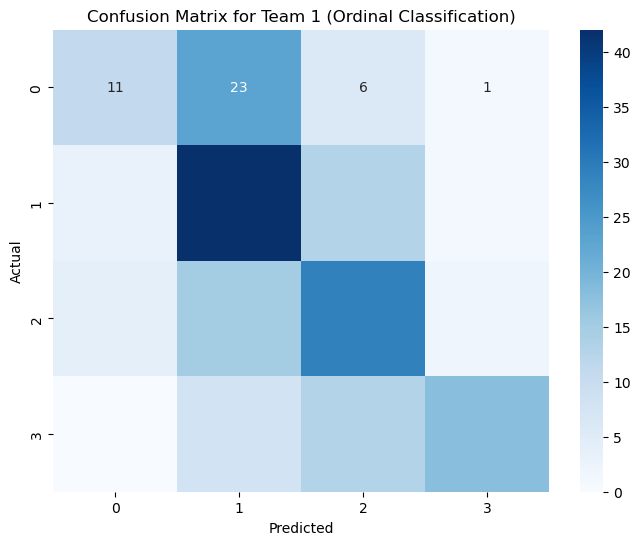

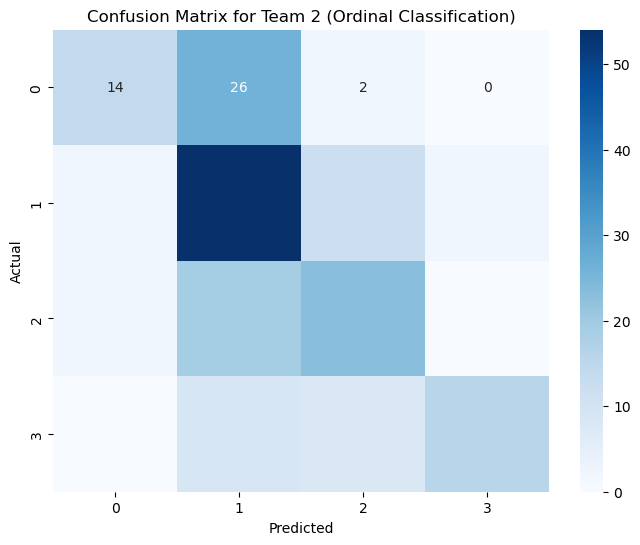

Accuracies of individual base models for Team 1:
Base model 1: 0.8042
Base model 2: 0.7407
Base model 3: 0.8730

Accuracies of individual base models for Team 2:
Base model 1: 0.8360
Base model 2: 0.7460
Base model 3: 0.9048


In [129]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Define features
X = data_imputed.drop(columns=['Team 1 Score', 'Team 2 Score'])
y_gt_2_team1 = (data_imputed['Team 1 Score'] > 2).astype(int)
y_gt_2_team2 = (data_imputed['Team 2 Score'] > 2).astype(int)

# Standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Define ordinal labels for Team 1 and Team 2
def create_ordinal_labels(score):
    if score <= 0:
        return 0
    elif score <= 1:
        return 1
    elif score <= 2:
        return 2
    else:
        return 3

y_team1 = data_imputed['Team 1 Score'].apply(create_ordinal_labels)
y_team2 = data_imputed['Team 2 Score'].apply(create_ordinal_labels)

# Function to train ordinal classifiers
def train_ordinal_classifiers(X, y):
    thresholds = sorted(y.unique())[:-1]  # Exclude the highest class
    classifiers = []
    
    for threshold in thresholds:
        # Create binary labels for the current threshold
        y_binary = (y > threshold).astype(int)
        
        # Train a binary classifier for this threshold
        classifier = LogisticRegression()
        classifier.fit(X, y_binary)
        classifiers.append(classifier)
    
    return classifiers

# Train ordinal classifiers for Team 1 and Team 2
ordinal_classifiers_team1 = train_ordinal_classifiers(X_scaled, y_team1)
ordinal_classifiers_team2 = train_ordinal_classifiers(X_scaled, y_team2)

# Function to predict ordinal classes
def predict_ordinal_classes(classifiers, X):
    probabilities = []
    for classifier in classifiers:
        prob = classifier.predict_proba(X)[:, 1]  # Probability of class > threshold
        probabilities.append(prob)
    
    # Combine probabilities to determine the final ordinal class
    probabilities = np.column_stack(probabilities)
    predictions = (probabilities > 0.5).sum(axis=1)  # Count thresholds exceeded
    return predictions

# Predict ordinal classes for Team 1 and Team 2
predictions_team1 = predict_ordinal_classes(ordinal_classifiers_team1, X_scaled)
predictions_team2 = predict_ordinal_classes(ordinal_classifiers_team2, X_scaled)

# Evaluate the ordinal classifiers
accuracy_team1 = accuracy_score(y_team1, predictions_team1)
accuracy_team2 = accuracy_score(y_team2, predictions_team2)

print(f"Ordinal Classification Accuracy for Team 1: {accuracy_team1:.4f}")
print(f"Ordinal Classification Accuracy for Team 2: {accuracy_team2:.4f}")

# Confusion Matrices
conf_matrix_team1 = confusion_matrix(y_team1, predictions_team1)
conf_matrix_team2 = confusion_matrix(y_team2, predictions_team2)

# Function to plot confusion matrices
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot Confusion Matrices
plot_confusion_matrix(conf_matrix_team1, "Confusion Matrix for Team 1 (Ordinal Classification)")
plot_confusion_matrix(conf_matrix_team2, "Confusion Matrix for Team 2 (Ordinal Classification)")

# Function to evaluate individual base models
def evaluate_base_models(classifiers, X, y):
    accuracies = []
    for i, classifier in enumerate(classifiers):
        # Create binary labels for the current threshold
        threshold = sorted(y.unique())[i]
        y_binary = (y > threshold).astype(int)
        
        # Predict and compute accuracy
        predictions = classifier.predict(X)
        accuracy = accuracy_score(y_binary, predictions)
        accuracies.append(accuracy)
    return accuracies

# Evaluate individual base models for Team 1 and Team 2
base_accuracies_team1 = evaluate_base_models(ordinal_classifiers_team1, X_scaled, y_team1)
base_accuracies_team2 = evaluate_base_models(ordinal_classifiers_team2, X_scaled, y_team2)

# Display accuracies
print("Accuracies of individual base models for Team 1:")
for i, acc in enumerate(base_accuracies_team1, start=1):
    print(f"Base model {i}: {acc:.4f}")

print("\nAccuracies of individual base models for Team 2:")
for i, acc in enumerate(base_accuracies_team2, start=1):
    print(f"Base model {i}: {acc:.4f}")

In [144]:
# Load the prediction table
prediction_file_path = r"prediction_data.csv"
prediction_data = pd.read_csv(prediction_file_path)

# prediction_data = prediction_data.drop(columns = ['Team 1 Score', 'Team 2 Score', 'B365H', 'B365D', 'B365A', 'H2H_Home_Total_Wins_Last_4', 'H2H_Away_Total_Wins_Last_4', 'H2H_Draws_Last_4'])

# Initialize arrays to hold ordinal class predictions for Team 1 and Team 2
ordinal_predictions_team1 = np.zeros((new_fixtures_scaled.shape[0], len(ordinal_classifiers_team1)))
ordinal_predictions_team2 = np.zeros((new_fixtures_scaled.shape[0], len(ordinal_classifiers_team2)))

# Generate ordinal class probabilities for Team 1
for i, model in enumerate(ordinal_classifiers_team1):
    ordinal_predictions_team1[:, i] = model.predict_proba(new_fixtures_scaled)[:, 1]  # Prob of > threshold

# Generate ordinal class probabilities for Team 2
for i, model in enumerate(ordinal_classifiers_team2):
    ordinal_predictions_team2[:, i] = model.predict_proba(new_fixtures_scaled)[:, 1]  # Prob of > threshold

# Combine ordinal probabilities into predictions
final_predictions_team1 = (ordinal_predictions_team1 > 0.5).sum(axis=1)  # Count thresholds exceeded
final_predictions_team2 = (ordinal_predictions_team2 > 0.5).sum(axis=1)  # Count thresholds exceeded

# Add predictions and probabilities back to the original prediction table
prediction_data['Team_1_Ordinal_Prediction'] = final_predictions_team1
prediction_data['Team_2_Ordinal_Prediction'] = final_predictions_team2

# Optional: Add highest ordinal class probability as a confidence score
prediction_data['Confidence_Team_1'] = np.max(ordinal_predictions_team1, axis=1)
prediction_data['Confidence_Team_2'] = np.max(ordinal_predictions_team2, axis=1)

# Display the results for the first 2 fixtures
prediction_results_ordinal = prediction_data[['Team 1', 'Team 2', 'Team_1_Ordinal_Prediction', 
                                              'Confidence_Team_1', 'Team_2_Ordinal_Prediction', 
                                              'Confidence_Team_2']]
print("Ordinal Predictions:")
prediction_results_ordinal.head(10) # Display first 2 rows only


Ordinal Predictions:


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarnin

,Team 1,Team 2,Team_1_Ordinal_Prediction,Confidence_Team_1,Team_2_Ordinal_Prediction,Confidence_Team_2
0,West Ham,Fulham,0,0.403322,2,0.888397
1,Brentford,Manchester City,2,0.911426,3,0.820965
2,Chelsea,Bournemouth,2,0.959201,2,0.891226
3,Nottingham Forest,Liverpool,2,0.934396,3,0.679584
4,Everton,Aston Villa,2,0.654221,2,0.688240
5,Leicester City,Crystal Palace,1,0.686997,2,0.691671
6,Newcastle Utd,Wolves,1,0.720817,1,0.557844
7,Arsenal,Tottenham,1,0.978304,1,0.502197
8,Ipswich Town,Brighton,1,0.808663,2,0.708292
9,Manchester Utd,Southampton,1,0.579178,1,0.739979


#### Safest bets by ordinal classifier

In [149]:
# Calculate the confidence difference
prediction_data['Confidence_Difference'] = abs(prediction_data['Confidence_Team_1'] - prediction_data['Confidence_Team_2'])

# Sort by the confidence difference in descending order (safest bets first)
safest_bets = prediction_data.sort_values(by='Confidence_Difference', ascending=False)

# Display the top matches with highest confidence difference
safest_bets_display = safest_bets[['Team 1', 'Team 2', 'Team_1_Ordinal_Prediction', 
                                   'Confidence_Team_1', 'Team_2_Ordinal_Prediction', 
                                   'Confidence_Team_2', 'Confidence_Difference']]

# Show the top 5 safest bets
safest_bets_display.head()


,Team 1,Team 2,Team_1_Ordinal_Prediction,Confidence_Team_1,Team_2_Ordinal_Prediction,Confidence_Team_2,Confidence_Difference
0,West Ham,Fulham,0,0.403322,2,0.888397,0.485075
7,Arsenal,Tottenham,1,0.978304,1,0.502197,0.476106
3,Nottingham Forest,Liverpool,2,0.934396,3,0.679584,0.254812
6,Newcastle Utd,Wolves,1,0.720817,1,0.557844,0.162973
9,Manchester Utd,Southampton,1,0.579178,1,0.739979,0.160802


In [152]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Define features and target for Win/Draw/Loss
X = data.drop(columns=["Team 1 Score", "Team 2 Score"])
y = np.where(data["Team 1 Score"] > data["Team 2 Score"], 0,   # Team 1 Win
             np.where(data["Team 1 Score"] == data["Team 2 Score"], 1,  # Draw
                      2))  # Team 2 Win

# Handle missing values using SimpleImputer on features only
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Base models
win_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42)
draw_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42)
loss_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42)

# Store results
win_accuracy_list = []
draw_accuracy_list = []
loss_accuracy_list = []

for train_index, test_index in kf.split(X_imputed):
    X_train, X_test = X_imputed.iloc[train_index], X_imputed.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]  # Using y for predictions

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate each model individually
    for model, acc_list, label in zip(
        [win_model, draw_model, loss_model],
        [win_accuracy_list, draw_accuracy_list, loss_accuracy_list],
        [0, 1, 2]
    ):
        y_train_binary = (y_train == label).astype(int)
        y_test_binary = (y_test == label).astype(int)
        
        model.fit(X_train_scaled, y_train_binary)
        y_pred_binary = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_binary, y_pred_binary)
        acc_list.append(accuracy)

# Calculate average accuracies
average_win_accuracy = np.mean(win_accuracy_list)
average_draw_accuracy = np.mean(draw_accuracy_list)
average_loss_accuracy = np.mean(loss_accuracy_list)

# Print results
print("Average Accuracy for Win Model:", average_win_accuracy)
print("Average Accuracy for Draw Model:", average_draw_accuracy)
print("Average Accuracy for Loss Model:", average_loss_accuracy)


Average Accuracy for Win Model: 0.6354196301564723
Average Accuracy for Draw Model: 0.6509246088193457
Average Accuracy for Loss Model: 0.6611664295874822


Ordinal Classification Accuracy for Team 1: 1.0000
Ordinal Classification Accuracy for Team 2: 1.0000


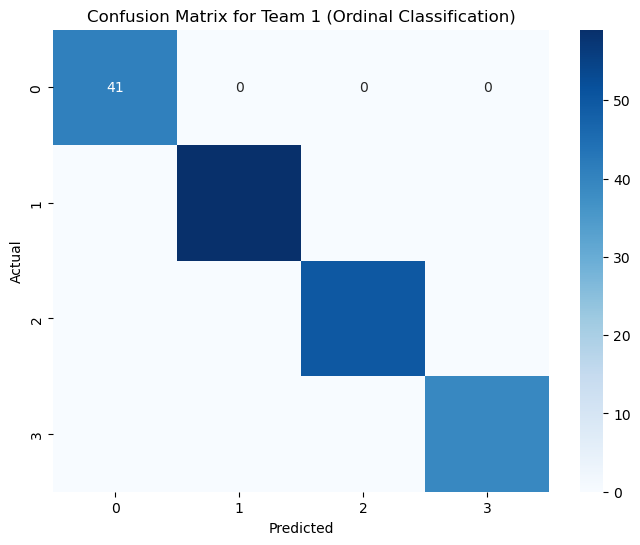

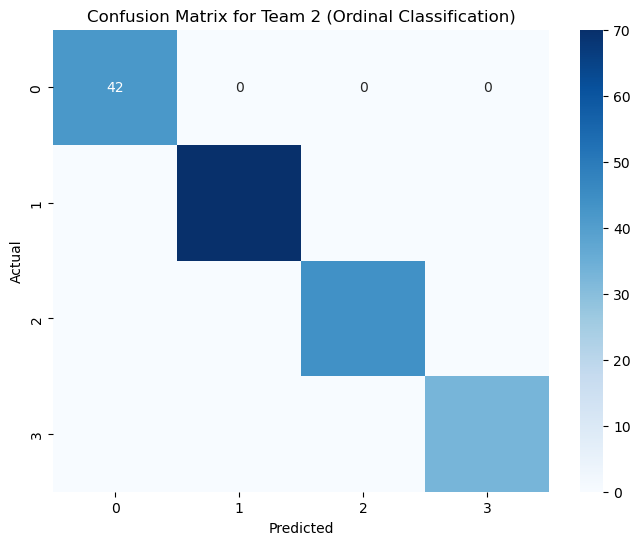

In [154]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Define features
X = data_imputed.drop(columns=['Team 1 Score', 'Team 2 Score'])
y_gt_2_team1 = (data_imputed['Team 1 Score'] > 2).astype(int)
y_gt_2_team2 = (data_imputed['Team 2 Score'] > 2).astype(int)

# Standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Define ordinal labels for Team 1 and Team 2
def create_ordinal_labels(score):
    if score <= 0:
        return 0
    elif score <= 1:
        return 1
    elif score <= 2:
        return 2
    else:
        return 3

y_team1 = data_imputed['Team 1 Score'].apply(create_ordinal_labels)
y_team2 = data_imputed['Team 2 Score'].apply(create_ordinal_labels)

# Function to train ordinal classifiers using RandomForestClassifier
def train_ordinal_classifiers(X, y):
    thresholds = sorted(y.unique())[:-1]  # Exclude the highest class
    classifiers = []
    
    for threshold in thresholds:
        # Create binary labels for the current threshold
        y_binary = (y > threshold).astype(int)
        
        # Train a binary classifier for this threshold
        classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        classifier.fit(X, y_binary)
        classifiers.append(classifier)
    
    return classifiers

# Train ordinal classifiers for Team 1 and Team 2
ordinal_classifiers_team1 = train_ordinal_classifiers(X_scaled, y_team1)
ordinal_classifiers_team2 = train_ordinal_classifiers(X_scaled, y_team2)

# Function to predict ordinal classes using RandomForestClassifier
def predict_ordinal_classes(classifiers, X):
    probabilities = []
    for classifier in classifiers:
        prob = classifier.predict_proba(X)[:, 1]  # Probability of class > threshold
        probabilities.append(prob)
    
    # Combine probabilities to determine the final ordinal class
    probabilities = np.column_stack(probabilities)
    predictions = (probabilities > 0.5).sum(axis=1)  # Count thresholds exceeded
    return predictions

# Predict ordinal classes for Team 1 and Team 2
predictions_team1 = predict_ordinal_classes(ordinal_classifiers_team1, X_scaled)
predictions_team2 = predict_ordinal_classes(ordinal_classifiers_team2, X_scaled)

# Evaluate the ordinal classifiers
accuracy_team1 = accuracy_score(y_team1, predictions_team1)
accuracy_team2 = accuracy_score(y_team2, predictions_team2)

print(f"Ordinal Classification Accuracy for Team 1: {accuracy_team1:.4f}")
print(f"Ordinal Classification Accuracy for Team 2: {accuracy_team2:.4f}")

# Confusion Matrices
conf_matrix_team1 = confusion_matrix(y_team1, predictions_team1)
conf_matrix_team2 = confusion_matrix(y_team2, predictions_team2)

# Function to plot confusion matrices
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot Confusion Matrices
plot_confusion_matrix(conf_matrix_team1, "Confusion Matrix for Team 1 (Ordinal Classification)")
plot_confusion_matrix(conf_matrix_team2, "Confusion Matrix for Team 2 (Ordinal Classification)")


In [156]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Define features and target for Win/Draw/Loss
X = data.drop(columns=["Team 1 Score", "Team 2 Score"])
y = np.where(data["Team 1 Score"] > data["Team 2 Score"], 0,   # Team 1 Win
             np.where(data["Team 1 Score"] == data["Team 2 Score"], 1,  # Draw
                      2))  # Team 2 Win

# Handle missing values using SimpleImputer on features only
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Base models using RandomForestClassifier
win_model = RandomForestClassifier(n_estimators=100, random_state=42)
draw_model = RandomForestClassifier(n_estimators=100, random_state=42)
loss_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Store results
win_accuracy_list = []
draw_accuracy_list = []
loss_accuracy_list = []

for train_index, test_index in kf.split(X_imputed):
    X_train, X_test = X_imputed.iloc[train_index], X_imputed.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]  # Using y for predictions

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate each model individually
    for model, acc_list, label in zip(
        [win_model, draw_model, loss_model],
        [win_accuracy_list, draw_accuracy_list, loss_accuracy_list],
        [0, 1, 2]
    ):
        y_train_binary = (y_train == label).astype(int)
        y_test_binary = (y_test == label).astype(int)
        
        model.fit(X_train_scaled, y_train_binary)
        y_pred_binary = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_binary, y_pred_binary)
        acc_list.append(accuracy)

# Calculate average accuracies
average_win_accuracy = np.mean(win_accuracy_list)
average_draw_accuracy = np.mean(draw_accuracy_list)
average_loss_accuracy = np.mean(loss_accuracy_list)

# Print results
print("Average Accuracy for Win Model:", average_win_accuracy)
print("Average Accuracy for Draw Model:", average_draw_accuracy)
print("Average Accuracy for Loss Model:", average_loss_accuracy)


Average Accuracy for Win Model: 0.5557610241820768
Average Accuracy for Draw Model: 0.6608819345661452
Average Accuracy for Loss Model: 0.7197724039829303


In [158]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Define features
X = data.drop(columns=['Team 1 Score', 'Team 2 Score'])  # Features for both teams

# Standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Create binary target variable for both teams scoring
y_both_score = ((data['Team 1 Score'] > 0) & (data['Team 2 Score'] > 0)).astype(int)

# List of targets for Team 1 and Team 2
targets_team1 = [(data['Team 1 Score'] > 0).astype(int)]  # Target for Team 1 scoring >0
targets_team2 = [(data['Team 2 Score'] > 0).astype(int)]  # Target for Team 2 scoring >0

# Initialize base models for Team 1 and Team 2
base_models_team1 = [RandomForestClassifier(n_estimators=100, random_state=42) for _ in targets_team1]
base_models_team2 = [RandomForestClassifier(n_estimators=100, random_state=42) for _ in targets_team2]

# Collect predictions for stacking
stacked_predictions_team1 = np.zeros((X_scaled.shape[0], len(base_models_team1)))
stacked_predictions_team2 = np.zeros((X_scaled.shape[0], len(base_models_team2)))

# K-Fold cross-validation for base models of Team 1
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train base models for Team 1
for i, (model, y) in enumerate(zip(base_models_team1, targets_team1)):
    fold_predictions = np.zeros(X_scaled.shape[0])  # For storing out-of-fold predictions

    for train_index, test_index in kf.split(X_scaled):
        # Split the data into training and testing sets
        X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the base model
        model.fit(X_train, y_train)

        # Store the out-of-fold predictions
        fold_predictions[test_index] = model.predict(X_test)

    # Store predictions for stacking
    stacked_predictions_team1[:, i] = fold_predictions

# K-Fold cross-validation for base models of Team 2
for i, (model, y) in enumerate(zip(base_models_team2, targets_team2)):
    fold_predictions = np.zeros(X_scaled.shape[0])  # For storing out-of-fold predictions

    for train_index, test_index in kf.split(X_scaled):
        # Split the data into training and testing sets
        X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the base model
        model.fit(X_train, y_train)

        # Store the out-of-fold predictions
        fold_predictions[test_index] = model.predict(X_test)

    # Store predictions for stacking
    stacked_predictions_team2[:, i] = fold_predictions

# Combine predictions from Team 1 and Team 2 base models for stacking
stacked_predictions = np.hstack((stacked_predictions_team1, stacked_predictions_team2))

# Stacking model to predict if both teams score
meta_model = LogisticRegression()
meta_model.fit(stacked_predictions, y_both_score)

# Predictions with the stacking model
final_predictions = meta_model.predict(stacked_predictions)

# Final model performance
final_accuracy = accuracy_score(y_both_score, final_predictions)
final_conf_matrix = confusion_matrix(y_both_score, final_predictions)

print("Stacking Model Results for Both Teams Scoring:")
print(f"Final Accuracy: {final_accuracy:.4f}")
print("Final Confusion Matrix:")
print(final_conf_matrix)

Stacking Model Results for Both Teams Scoring:
Final Accuracy: 0.6455
Final Confusion Matrix:
[[  7  65]
 [  2 115]]


In [160]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Define features and target for Win/Draw/Loss
X = data.drop(columns=["Team 1 Score", "Team 2 Score"])
y = np.where(data["Team 1 Score"] > data["Team 2 Score"], 0,   # Team 1 Win
             np.where(data["Team 1 Score"] == data["Team 2 Score"], 1,  # Draw
                      2))  # Team 2 Win

# Handle missing values using SimpleImputer on features only
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Base models
base_models = [
    ('win_model', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
    ('draw_model', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
    ('loss_model', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
]

# Stacking Classifier
meta_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Store results
accuracy_list = []
classification_reports = []

for train_index, test_index in kf.split(X_imputed):
    X_train, X_test = X_imputed.iloc[train_index], X_imputed.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]  # Using y for predictions

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the stacking model
    stacked_model.fit(X_train_scaled, y_train)  # Ensure y_train is 1D

    # Make predictions
    y_pred = stacked_model.predict(X_test_scaled)

    # Calculate accuracy and store results
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    classification_reports.append(classification_report(y_test, y_pred, output_dict=True))

# Output average accuracy and classification report
average_accuracy = np.mean(accuracy_list)
print("Average Accuracy:", average_accuracy)

# Print detailed classification reports for each fold
for i, report in enumerate(classification_reports):
    print(f"\nClassification Report for Fold {i + 1}:\n", report)


Average Accuracy: 0.4499288762446657

Classification Report for Fold 1:
 {'0': {'precision': 0.6818181818181818, 'recall': 0.8823529411764706, 'f1-score': 0.7692307692307693, 'support': 17.0}, '1': {'precision': 0.3, 'recall': 0.375, 'f1-score': 0.3333333333333333, 'support': 8.0}, '2': {'precision': 0.6666666666666666, 'recall': 0.3076923076923077, 'f1-score': 0.42105263157894735, 'support': 13.0}, 'accuracy': 0.5789473684210527, 'macro avg': {'precision': 0.5494949494949495, 'recall': 0.5216817496229261, 'f1-score': 0.50787224471435, 'support': 38.0}, 'weighted avg': {'precision': 0.5962519936204146, 'recall': 0.5789473684210527, 'f1-score': 0.5583493145820015, 'support': 38.0}}

Classification Report for Fold 2:
 {'0': {'precision': 0.5882352941176471, 'recall': 0.7142857142857143, 'f1-score': 0.6451612903225806, 'support': 14.0}, '1': {'precision': 0.4166666666666667, 'recall': 0.45454545454545453, 'f1-score': 0.43478260869565216, 'support': 11.0}, '2': {'precision': 0.555555555555

In [204]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Define features and target for Win/Draw/Loss
X = data.drop(columns=["Team 1 Score", "Team 2 Score"])
y = np.where(data["Team 1 Score"] > data["Team 2 Score"], 0,  # Team 1 Win
             np.where(data["Team 1 Score"] == data["Team 2 Score"], 1,  # Draw
                      2))  # Team 2 Win

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA for dimensionality reduction
n_components = 10  # Number of PCA components (adjust based on dataset)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Print explained variance for the chosen number of components
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance with {n_components} components: {explained_variance:.2f}")

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Base models for stacking
base_models = [
    ('win_model', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
    ('draw_model', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
    ('loss_model', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
]

# Meta model for stacking
meta_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Store results
accuracy_list = []
classification_reports = []

# Cross-validation loop
for train_index, test_index in kf.split(X_pca):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the stacking model
    stacked_model.fit(X_train, y_train)

    # Make predictions
    y_pred = stacked_model.predict(X_test)

    # Calculate accuracy and store results
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    classification_reports.append(classification_report(y_test, y_pred, output_dict=True))

# Output average accuracy and classification report
average_accuracy = np.mean(accuracy_list)
print(f"\nAverage Accuracy: {average_accuracy:.2f}")

# Print detailed classification reports for each fold
for i, report in enumerate(classification_reports):
    print(f"\nClassification Report for Fold {i + 1}:\n", report)


Explained Variance with 10 components: 0.81

Average Accuracy: 0.42

Classification Report for Fold 1:
 {'0': {'precision': 0.5263157894736842, 'recall': 0.5882352941176471, 'f1-score': 0.5555555555555556, 'support': 17.0}, '1': {'precision': 0.13333333333333333, 'recall': 0.25, 'f1-score': 0.17391304347826086, 'support': 8.0}, '2': {'precision': 0.5, 'recall': 0.15384615384615385, 'f1-score': 0.23529411764705882, 'support': 13.0}, 'accuracy': 0.3684210526315789, 'macro avg': {'precision': 0.38654970760233914, 'recall': 0.3306938159879336, 'f1-score': 0.3215875722269584, 'support': 38.0}, 'weighted avg': {'precision': 0.43457987072945525, 'recall': 0.3684210526315789, 'f1-score': 0.365646640044271, 'support': 38.0}}

Classification Report for Fold 2:
 {'0': {'precision': 0.5333333333333333, 'recall': 0.5714285714285714, 'f1-score': 0.5517241379310345, 'support': 14.0}, '1': {'precision': 0.5714285714285714, 'recall': 0.36363636363636365, 'f1-score': 0.4444444444444444, 'support': 11.0}

In [162]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

# Handle missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Standardize features
X = data_imputed.drop(columns=['Team 1 Score', 'Team 2 Score'])
y_team1_score = data_imputed['Team 1 Score']
y_team2_score = data_imputed['Team 2 Score']
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 1. Win/Draw/Loss Model
def create_wdl_labels(score_team1, score_team2):
    if score_team1 > score_team2:
        return 1  # Win
    elif score_team1 < score_team2:
        return -1  # Loss
    else:
        return 0  # Draw

y_wdl = data_imputed.apply(lambda row: create_wdl_labels(row['Team 1 Score'], row['Team 2 Score']), axis=1)

# Train WDL model
wdl_model = LogisticRegression(multi_class='multinomial', max_iter=200)
wdl_model.fit(X_scaled, y_wdl)
wdl_probs = wdl_model.predict_proba(X_scaled)

# Compute "safest" WDL bets
wdl_safest_bets = np.abs(wdl_probs[:, 1] - wdl_probs[:, 2])  # Difference between win and loss probabilities

# 2. Over/Under 2.5 Goals
y_over_under_team1 = (y_team1_score > 2).astype(int)
y_over_under_team2 = (y_team2_score > 2).astype(int)

ou_model_team1 = LogisticRegression()
ou_model_team2 = LogisticRegression()
ou_model_team1.fit(X_scaled, y_over_under_team1)
ou_model_team2.fit(X_scaled, y_over_under_team2)

ou_probs_team1 = ou_model_team1.predict_proba(X_scaled)[:, 1]
ou_probs_team2 = ou_model_team2.predict_proba(X_scaled)[:, 1]

# Combine over/under probabilities
ou_combined_probs = (ou_probs_team1 + ou_probs_team2) / 2

# 3. Both Teams to Score (BTTS)
y_btts = ((y_team1_score > 0) & (y_team2_score > 0)).astype(int)

# Stacking model for BTTS
kf = KFold(n_splits=5, shuffle=True, random_state=42)
btts_base_model = RandomForestClassifier(n_estimators=100, random_state=42)
btts_predictions = np.zeros(X_scaled.shape[0])

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y_train, y_test = y_btts.iloc[train_idx], y_btts.iloc[test_idx]
    btts_base_model.fit(X_train, y_train)
    btts_predictions[test_idx] = btts_base_model.predict_proba(X_test)[:, 1]

# Final stacking model
meta_model = LogisticRegression()
meta_model.fit(btts_predictions.reshape(-1, 1), y_btts)
btts_probs = meta_model.predict_proba(btts_predictions.reshape(-1, 1))[:, 1]

# Combine results into tables
results = pd.DataFrame({
    'Fixture': range(len(data_imputed)),  # Placeholder for fixtures
    'Win_Prob': wdl_probs[:, 1],
    'Loss_Prob': wdl_probs[:, 2],
    'Draw_Prob': wdl_probs[:, 0],
    'WDL_Safest_Bet': wdl_safest_bets,
    'OU_Prob': ou_combined_probs,
    'BTTS_Prob': btts_probs
})

# Sort tables
wdl_table = results.sort_values(by='WDL_Safest_Bet', ascending=False)
ou_table = results.sort_values(by='OU_Prob', ascending=False)
btts_table = results.sort_values(by='BTTS_Prob', ascending=False)

# Save or display tables
wdl_table.to_csv("wdl_table.csv", index=False)
ou_table.to_csv("ou_table.csv", index=False)
btts_table.to_csv("btts_table.csv", index=False)

print("Tables created and saved as CSV files.")


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Tables created and saved as CSV files.


Binary Classification Accuracy for Over/Under 2.5 Goals: 0.7407
[[42 33]
 [16 98]]


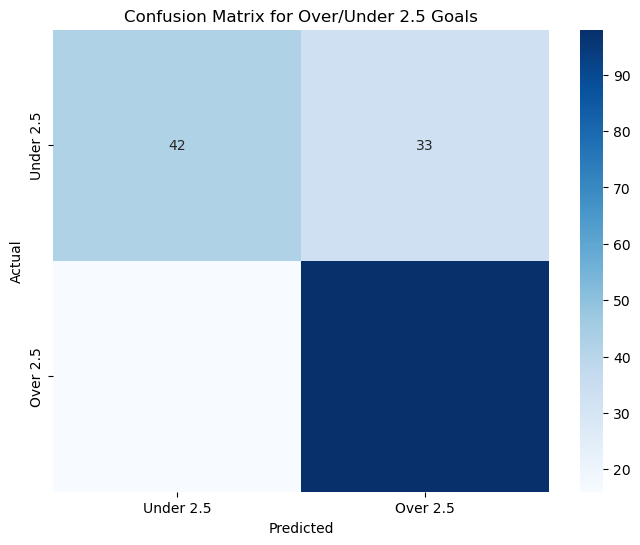

In [166]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Define features
X = data_imputed.drop(columns=['Team 1 Score', 'Team 2 Score'])
y_total_score = data_imputed['Team 1 Score'] + data_imputed['Team 2 Score']

# Create binary target variable for over/under 2.5 goals
y_over_under = (y_total_score > 2.5).astype(int)

# Standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train a binary classifier
classifier = LogisticRegression()
classifier.fit(X_scaled, y_over_under)

# Predict and evaluate the classifier
predictions = classifier.predict(X_scaled)
accuracy = accuracy_score(y_over_under, predictions)

print(f"Binary Classification Accuracy for Over/Under 2.5 Goals: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_over_under, predictions)
print(conf_matrix)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Under 2.5', 'Over 2.5'], yticklabels=['Under 2.5', 'Over 2.5'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(conf_matrix, "Confusion Matrix for Over/Under 2.5 Goals")


In [213]:
# Import required libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder


new_data = new_fixtures.copy()
# Add 'Team 1' and 'Team 2' columns back to new_data from nf_copy
new_data['Team 1'] = nf_copy['Team 1']
new_data['Team 2'] = nf_copy['Team 2']

# Ensure the columns are correctly added
print(new_data.head())

# Separate numeric and non-numeric columns
numeric_columns = new_data.select_dtypes(include=['float64', 'int64']).columns
non_numeric_columns = new_data.select_dtypes(exclude=['float64', 'int64']).columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Assuming the column causing the issue is named 'Predictions'
# Apply label encoding
new_data['Predictions'] = label_encoder.fit_transform(new_data['Predictions'])

# Check the mapping of encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:", label_mapping)

# Handle missing values only for numeric columns
imputer = SimpleImputer(strategy='mean')
new_data_numeric = pd.DataFrame(imputer.fit_transform(new_data[numeric_columns]), columns=numeric_columns)

# Combine the numeric and non-numeric columns
new_data_imputed = pd.concat([new_data_numeric, new_data[non_numeric_columns].reset_index(drop=True)], axis=1)

# Ensure feature columns match the training dataset
X_new = new_data_imputed[X.columns]  # Use the same features as the training dataset

# Standardize the new dataset using the same scaler
X_new_scaled = pd.DataFrame(scaler.transform(X_new), columns=X.columns)

# Predict using the trained model
new_predictions = classifier.predict(X_new_scaled)
new_probabilities = classifier.predict_proba(X_new_scaled)

# Add predictions and probabilities back to the original dataset
new_data_imputed['Total_Over_Under_Prediction'] = new_predictions
new_data_imputed['Probability_Under_2.5'] = new_probabilities[:, 0]
new_data_imputed['Probability_Over_2.5'] = new_probabilities[:, 1]

# Display the results including team names
output_columns = ['Team 1', 'Team 2', 'Total_Over_Under_Prediction', 'Probability_Under_2.5', 'Probability_Over_2.5']
print("Predictions for New Dataset:")
print(new_data_imputed[output_columns].head())

# Save the predictions to a CSV file
output_file_path = r"C:\path_to_output\predictions.csv"
new_data_imputed.to_csv(output_file_path, index=False)
print(f"Predictions saved to {output_file_path}")

   Prev Team 1 Form  Prev Team 2 Form  Prev Team 1 Goal Difference  \
0               1.0               1.4                          -15   
1               0.8               1.4                            3   
2               1.0               1.8                           15   
3               3.0               2.2                           10   
4               0.6               1.4                          -10   

   Prev Team 2 Goal Difference  Prev Team 1 Points  Prev Team 2 Points  \
0                            3                  23                  30   
1                            9                  27                  34   
2                            7                  36                  33   
3                           28                  40                  46   
4                           -2                  17                  32   

   Cumulative_Avg_HST  Cumulative_Avg_AST  Cumulative_Avg_HF  \
0            5.100000            4.050000           9.950000   
1     

In [215]:
new_data_imputed[output_columns].head()

,Team 1,Team 2,Total_Over_Under_Prediction,Probability_Under_2.5,Probability_Over_2.5
0,West Ham,Fulham,1,0.317981,0.682019
1,Brentford,Manchester City,1,0.087128,0.912872
2,Chelsea,Bournemouth,1,0.121864,0.878136
3,Nottingham Forest,Liverpool,1,0.364527,0.635473
4,Everton,Aston Villa,1,0.380075,0.619925


#### Safest bets for total over/under 2.5 goals

In [219]:
# Add a column for confidence in the predicted outcome
# Confidence is the probability of the predicted class
new_data_imputed['Confidence'] = new_data_imputed.apply(
    lambda row: row['Probability_Over_2.5'] if row['Total_Over_Under_Prediction'] == 1 else row['Probability_Under_2.5'], 
    axis=1
)

# Sort by confidence in descending order (safest bets first)
sorted_bets = new_data_imputed.sort_values(by='Confidence', ascending=False)

# Display the top safest bets
output_columns = ['Team 1', 'Team 2', 'Total_Over_Under_Prediction', 'Confidence', 'Probability_Under_2.5', 'Probability_Over_2.5']
print("Safest Bets:")
print(sorted_bets[output_columns].head())

# Save the sorted bets to a CSV file
sorted_bets_output_file = r"C:\path_to_output\sorted_bets.csv"
sorted_bets[output_columns].to_csv(sorted_bets_output_file, index=False)
print(f"Sorted safest bets saved to {sorted_bets_output_file}")


Safest Bets:
              Team 1           Team 2  Total_Over_Under_Prediction  \
1          Brentford  Manchester City                            1   
2            Chelsea      Bournemouth                            1   
0           West Ham           Fulham                            1   
6      Newcastle Utd           Wolves                            1   
3  Nottingham Forest        Liverpool                            1   

   Confidence  Probability_Under_2.5  Probability_Over_2.5  
1    0.912872               0.087128              0.912872  
2    0.878136               0.121864              0.878136  
0    0.682019               0.317981              0.682019  
6    0.674071               0.325929              0.674071  
3    0.635473               0.364527              0.635473  
Sorted safest bets saved to C:\path_to_output\sorted_bets.csv


In [229]:
sorted_bets[output_columns].head(10)

,Team 1,Team 2,Total_Over_Under_Prediction,Confidence,Probability_Under_2.5,Probability_Over_2.5
1,Brentford,Manchester City,1,0.912872,0.087128,0.912872
2,Chelsea,Bournemouth,1,0.878136,0.121864,0.878136
0,West Ham,Fulham,1,0.682019,0.317981,0.682019
6,Newcastle Utd,Wolves,1,0.674071,0.325929,0.674071
3,Nottingham Forest,Liverpool,1,0.635473,0.364527,0.635473
4,Everton,Aston Villa,1,0.619925,0.380075,0.619925
5,Leicester City,Crystal Palace,1,0.603784,0.396216,0.603784
8,Ipswich Town,Brighton,0,0.586381,0.586381,0.413619
9,Manchester Utd,Southampton,0,0.526018,0.526018,0.473982
7,Arsenal,Tottenham,1,0.521200,0.478800,0.521200


In [227]:
safest_bets_display.head(10)

,Team 1,Team 2,Team_1_Ordinal_Prediction,Confidence_Team_1,Team_2_Ordinal_Prediction,Confidence_Team_2,Confidence_Difference
0,West Ham,Fulham,0,0.403322,2,0.888397,0.485075
7,Arsenal,Tottenham,1,0.978304,1,0.502197,0.476106
3,Nottingham Forest,Liverpool,2,0.934396,3,0.679584,0.254812
6,Newcastle Utd,Wolves,1,0.720817,1,0.557844,0.162973
9,Manchester Utd,Southampton,1,0.579178,1,0.739979,0.160802
8,Ipswich Town,Brighton,1,0.808663,2,0.708292,0.100372
1,Brentford,Manchester City,2,0.911426,3,0.820965,0.090460
2,Chelsea,Bournemouth,2,0.959201,2,0.891226,0.067975
4,Everton,Aston Villa,2,0.654221,2,0.688240,0.034020
5,Leicester City,Crystal Palace,1,0.686997,2,0.691671,0.004674


In [225]:
sorted_output[['Team 1', 'Team 2', 'Predictions', 'Team 1 Win Probability', 
               'Draw Probability', 'Team 2 Win Probability', 'Safety Metric']].head()


,Team 1,Team 2,Predictions,Team 1 Win Probability,Draw Probability,Team 2 Win Probability,Safety Metric
0,West Ham,Fulham,Draw,0.285176,0.378181,0.336644,0.378181
7,Arsenal,Tottenham,Team 1 Wins,0.522884,0.228891,0.248225,0.274659
1,Brentford,Manchester City,Team 1 Wins,0.491199,0.269814,0.238987,0.252212
2,Chelsea,Bournemouth,Team 1 Wins,0.482760,0.246903,0.270337,0.212424
5,Leicester City,Crystal Palace,Team 1 Wins,0.414346,0.320225,0.265429,0.148917
